
📊 Processing IOWait with Simple Isolation Forest:
  🔍 NETWORKLOSS:
    ✅ Cleaned 24 outliers (5.0%) using 10 original features
  🔍 BASELINE:
    ✅ Cleaned 24 outliers (5.0%) using 10 original features

📊 Processing IRQ with Simple Isolation Forest:
  🔍 NETWORKLOSS:
    ✅ Cleaned 24 outliers (5.0%) using 10 original features
  🔍 BASELINE:
    ✅ Cleaned 22 outliers (4.5%) using 10 original features

📊 Processing System with Simple Isolation Forest:
  🔍 NETWORKLOSS:
    ✅ Cleaned 25 outliers (5.2%) using 10 original features
  🔍 BASELINE:
    ✅ Cleaned 24 outliers (4.9%) using 10 original features

📊 Processing User with Simple Isolation Forest:
  🔍 NETWORKLOSS:
    ✅ Cleaned 24 outliers (4.9%) using 10 original features
  🔍 BASELINE:
    ✅ Cleaned 25 outliers (5.2%) using 10 original features

📊 Processing Utilization with Simple Isolation Forest:
  🔍 NETWORKLOSS:
    ✅ Cleaned 24 outliers (4.9%) using 10 original features
  🔍 BASELINE:
    ✅ Cleaned 21 outliers (4.4%) using 10 original

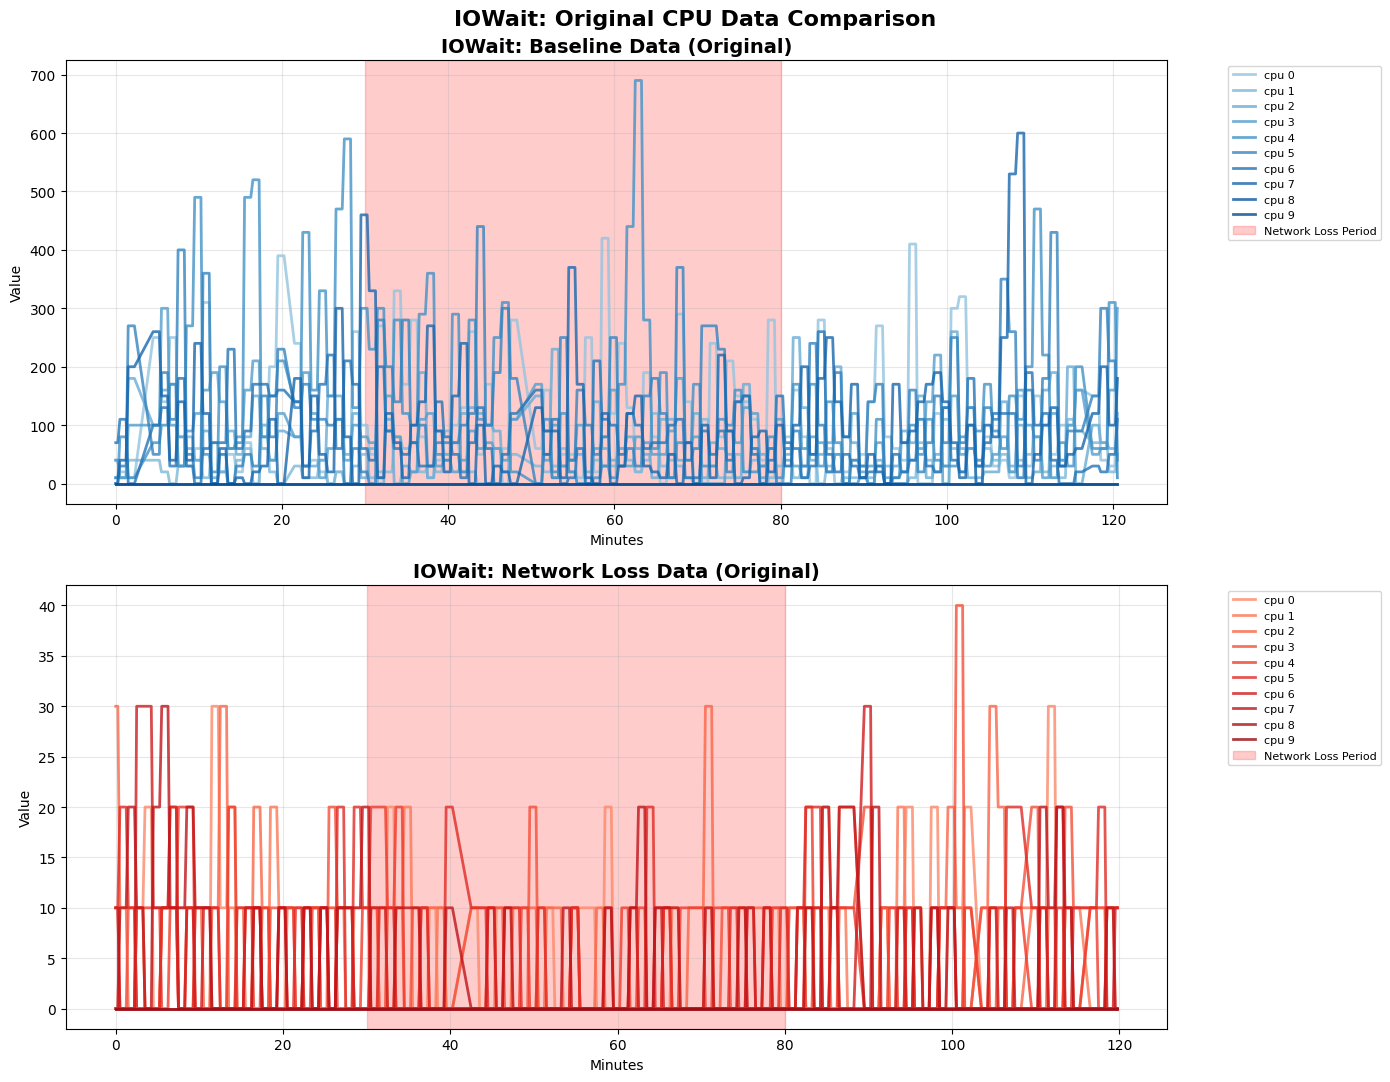

  💡 Displayed all 10 CPU columns: cpu 0, cpu 1, cpu 2, cpu 3, cpu 4, cpu 5, cpu 6, cpu 7, cpu 8, cpu 9


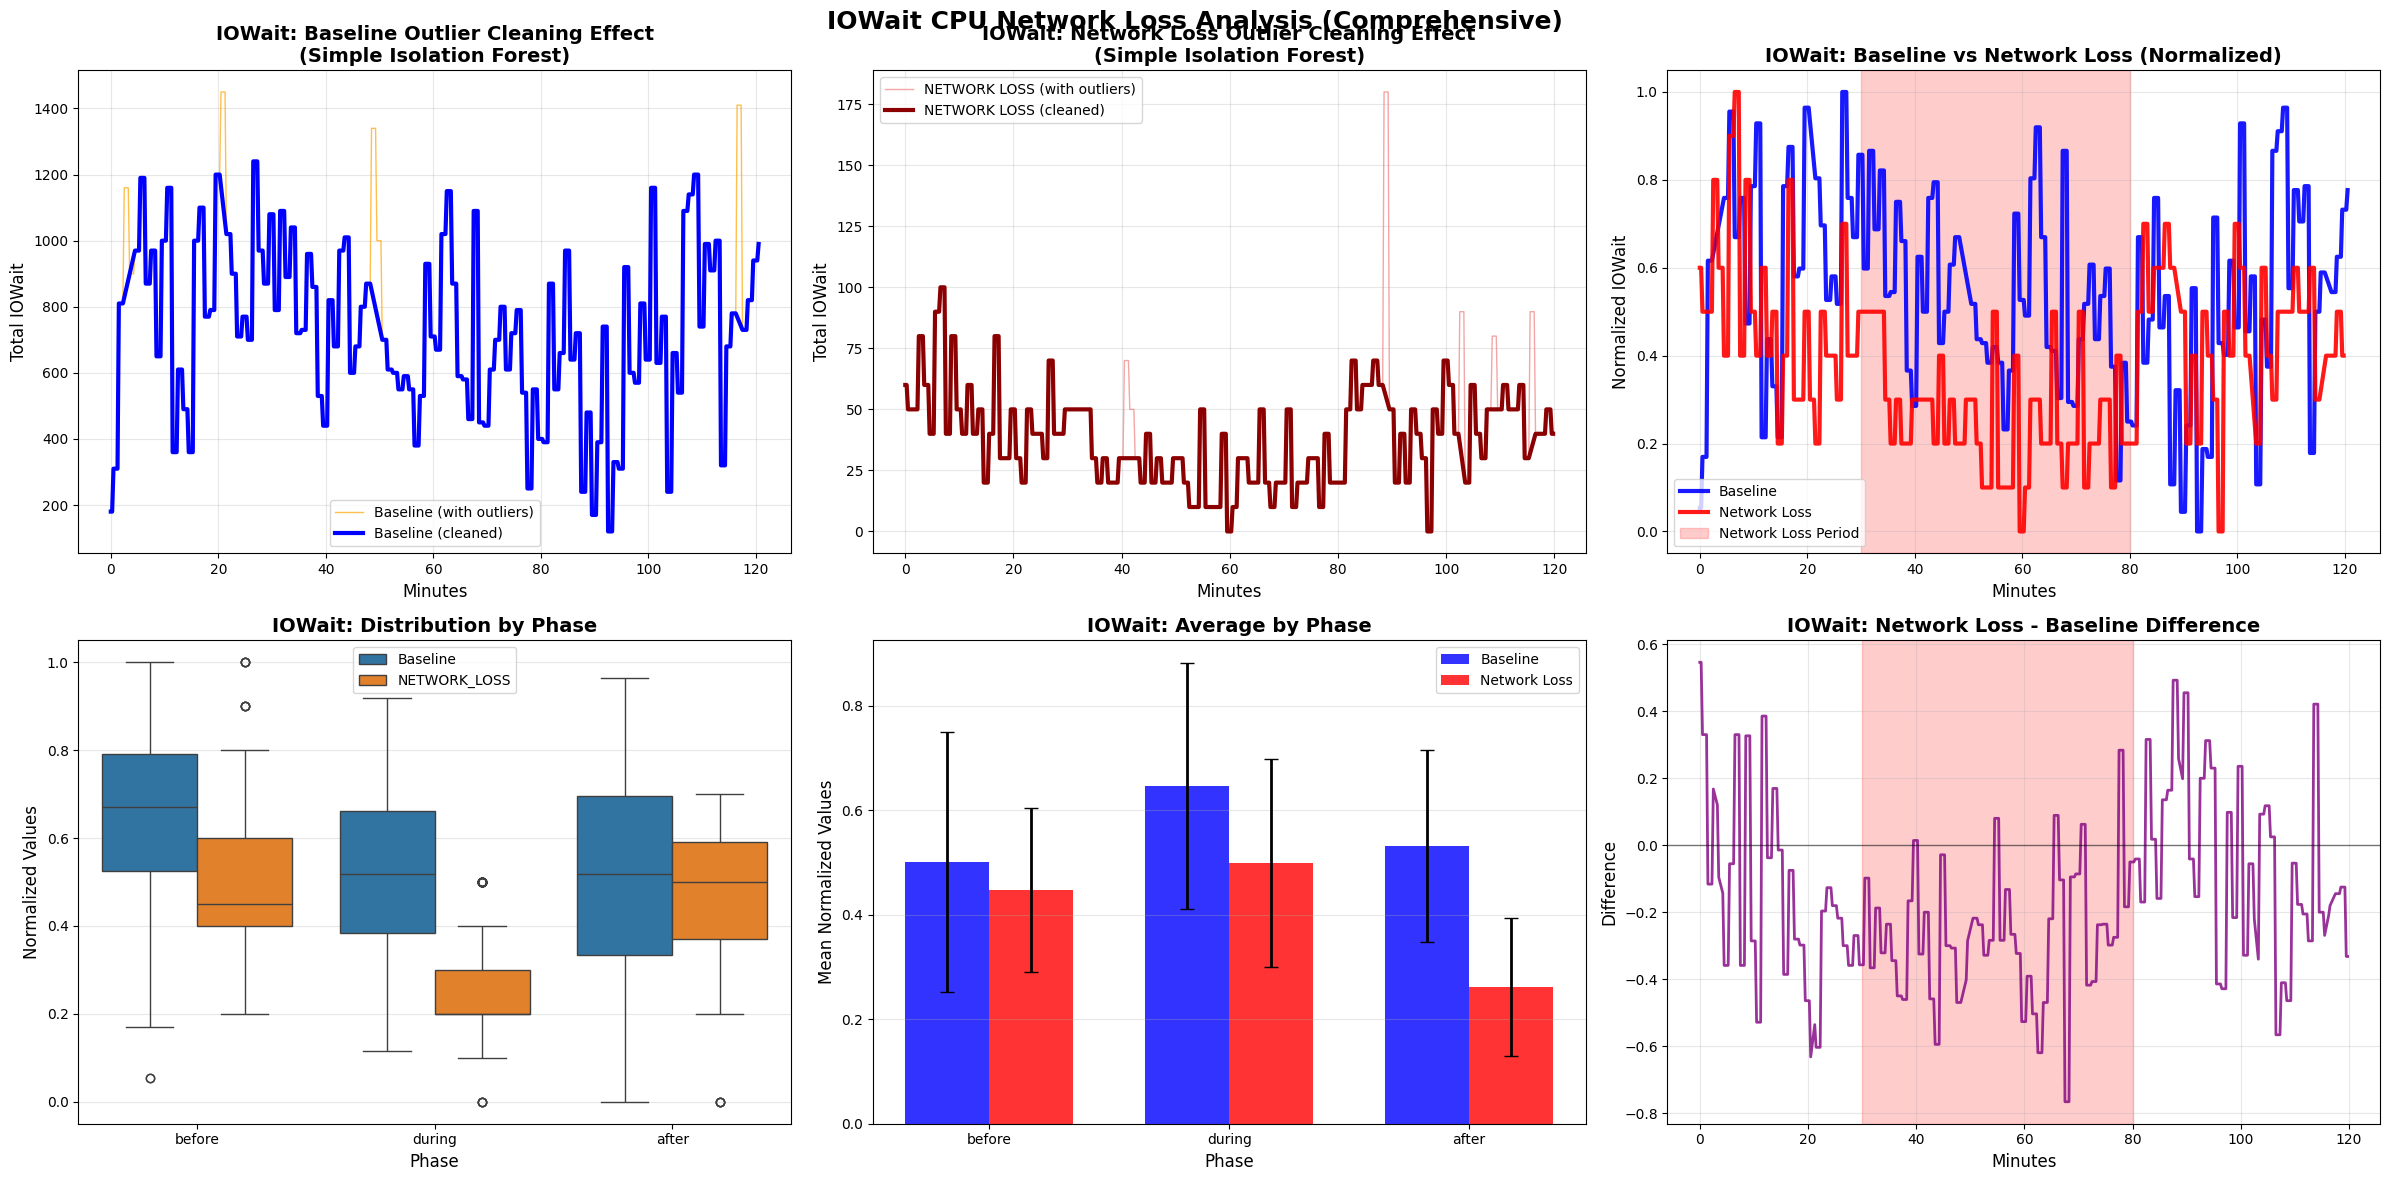


IOWAIT - CPU NETWORK LOSS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.5005  0.2483  0.0000  0.9643
before  0.6461  0.2346  0.0536  1.0000
during  0.5313  0.1842  0.1161  0.9196

📊 NETWORK LOSS STATISTICS BY PHASE:
          mean     std  min  max
phase                           
after   0.4465  0.1569  0.0  0.7
before  0.4983  0.1987  0.2  1.0
during  0.2607  0.1319  0.0  0.5

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  5.27, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 16.93, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=  2.32, p=  0.0208 (✅ SIGNIFICANT)

📈 NETWORK LOSS IMPACT ON CPU (% CHANGE):
  BEFORE  :  -22.87% (↘️ DECREASE)
  DURING  :  -50.93% (↘️ DECREASE)
  AFTER   :  -10.78% (↘️ DECREASE)

📋 INDIVIDUAL CPU METRICS SUMMARY:
  CPU columns found: ['cpu 0', 'cpu 1', 'cpu 2', 'cpu 3', 'cpu 4', 'cpu 5', 'cpu 6', 'cpu 7', 'cpu 8', 'cpu 9']
  Total metrics analyzed: 10

🔄 Analyzing IRQ...



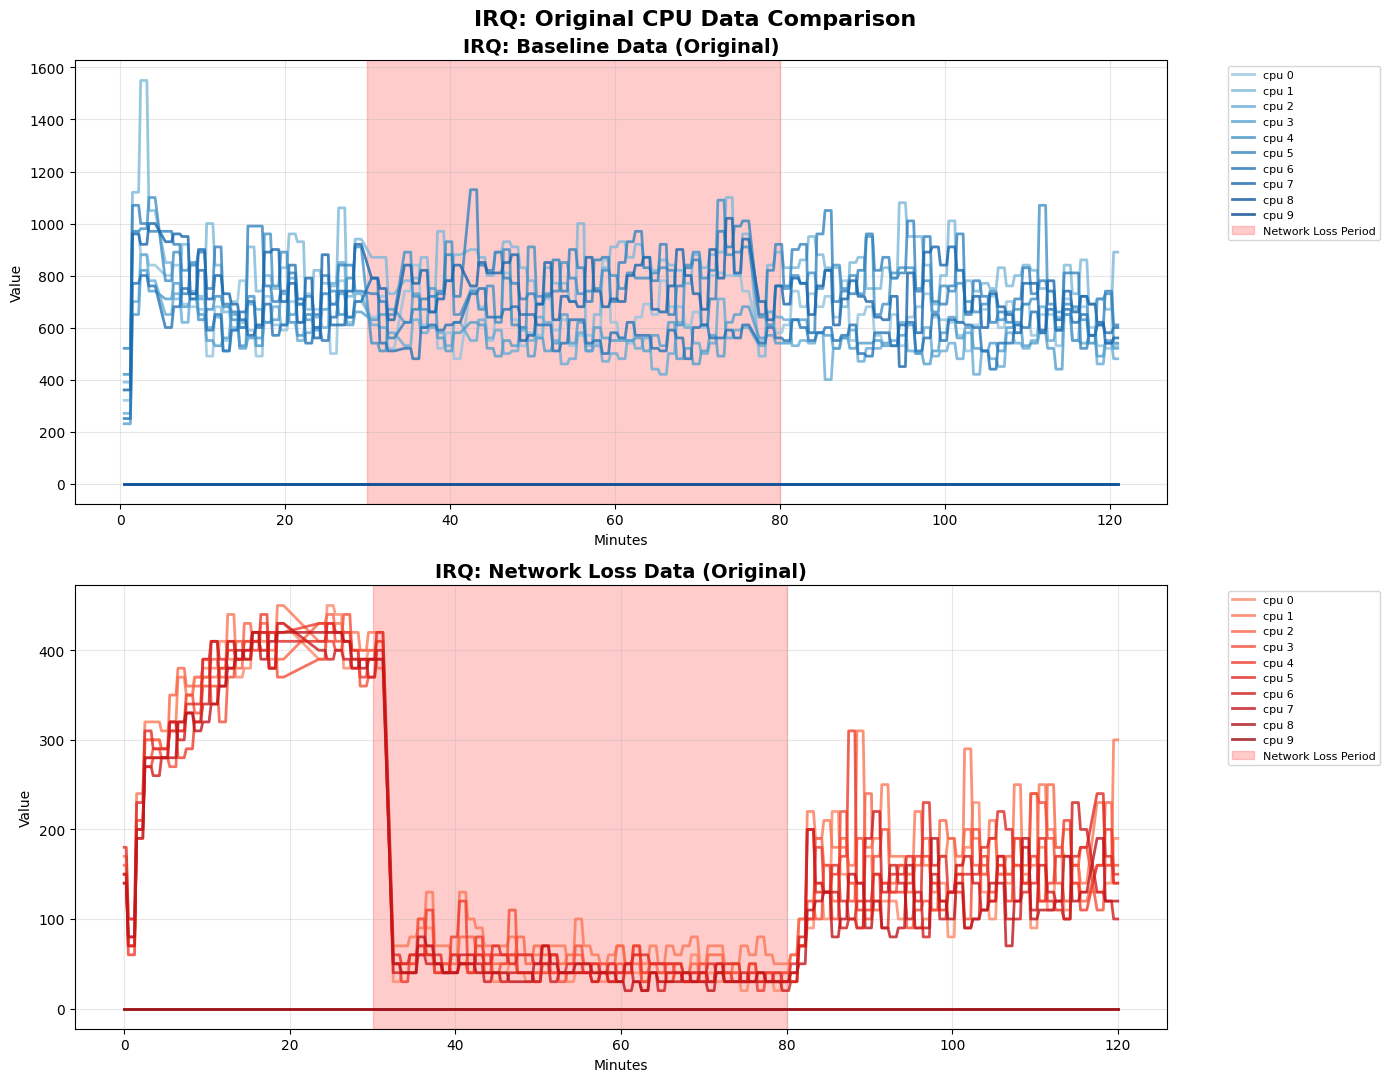

  💡 Displayed all 10 CPU columns: cpu 0, cpu 1, cpu 2, cpu 3, cpu 4, cpu 5, cpu 6, cpu 7, cpu 8, cpu 9


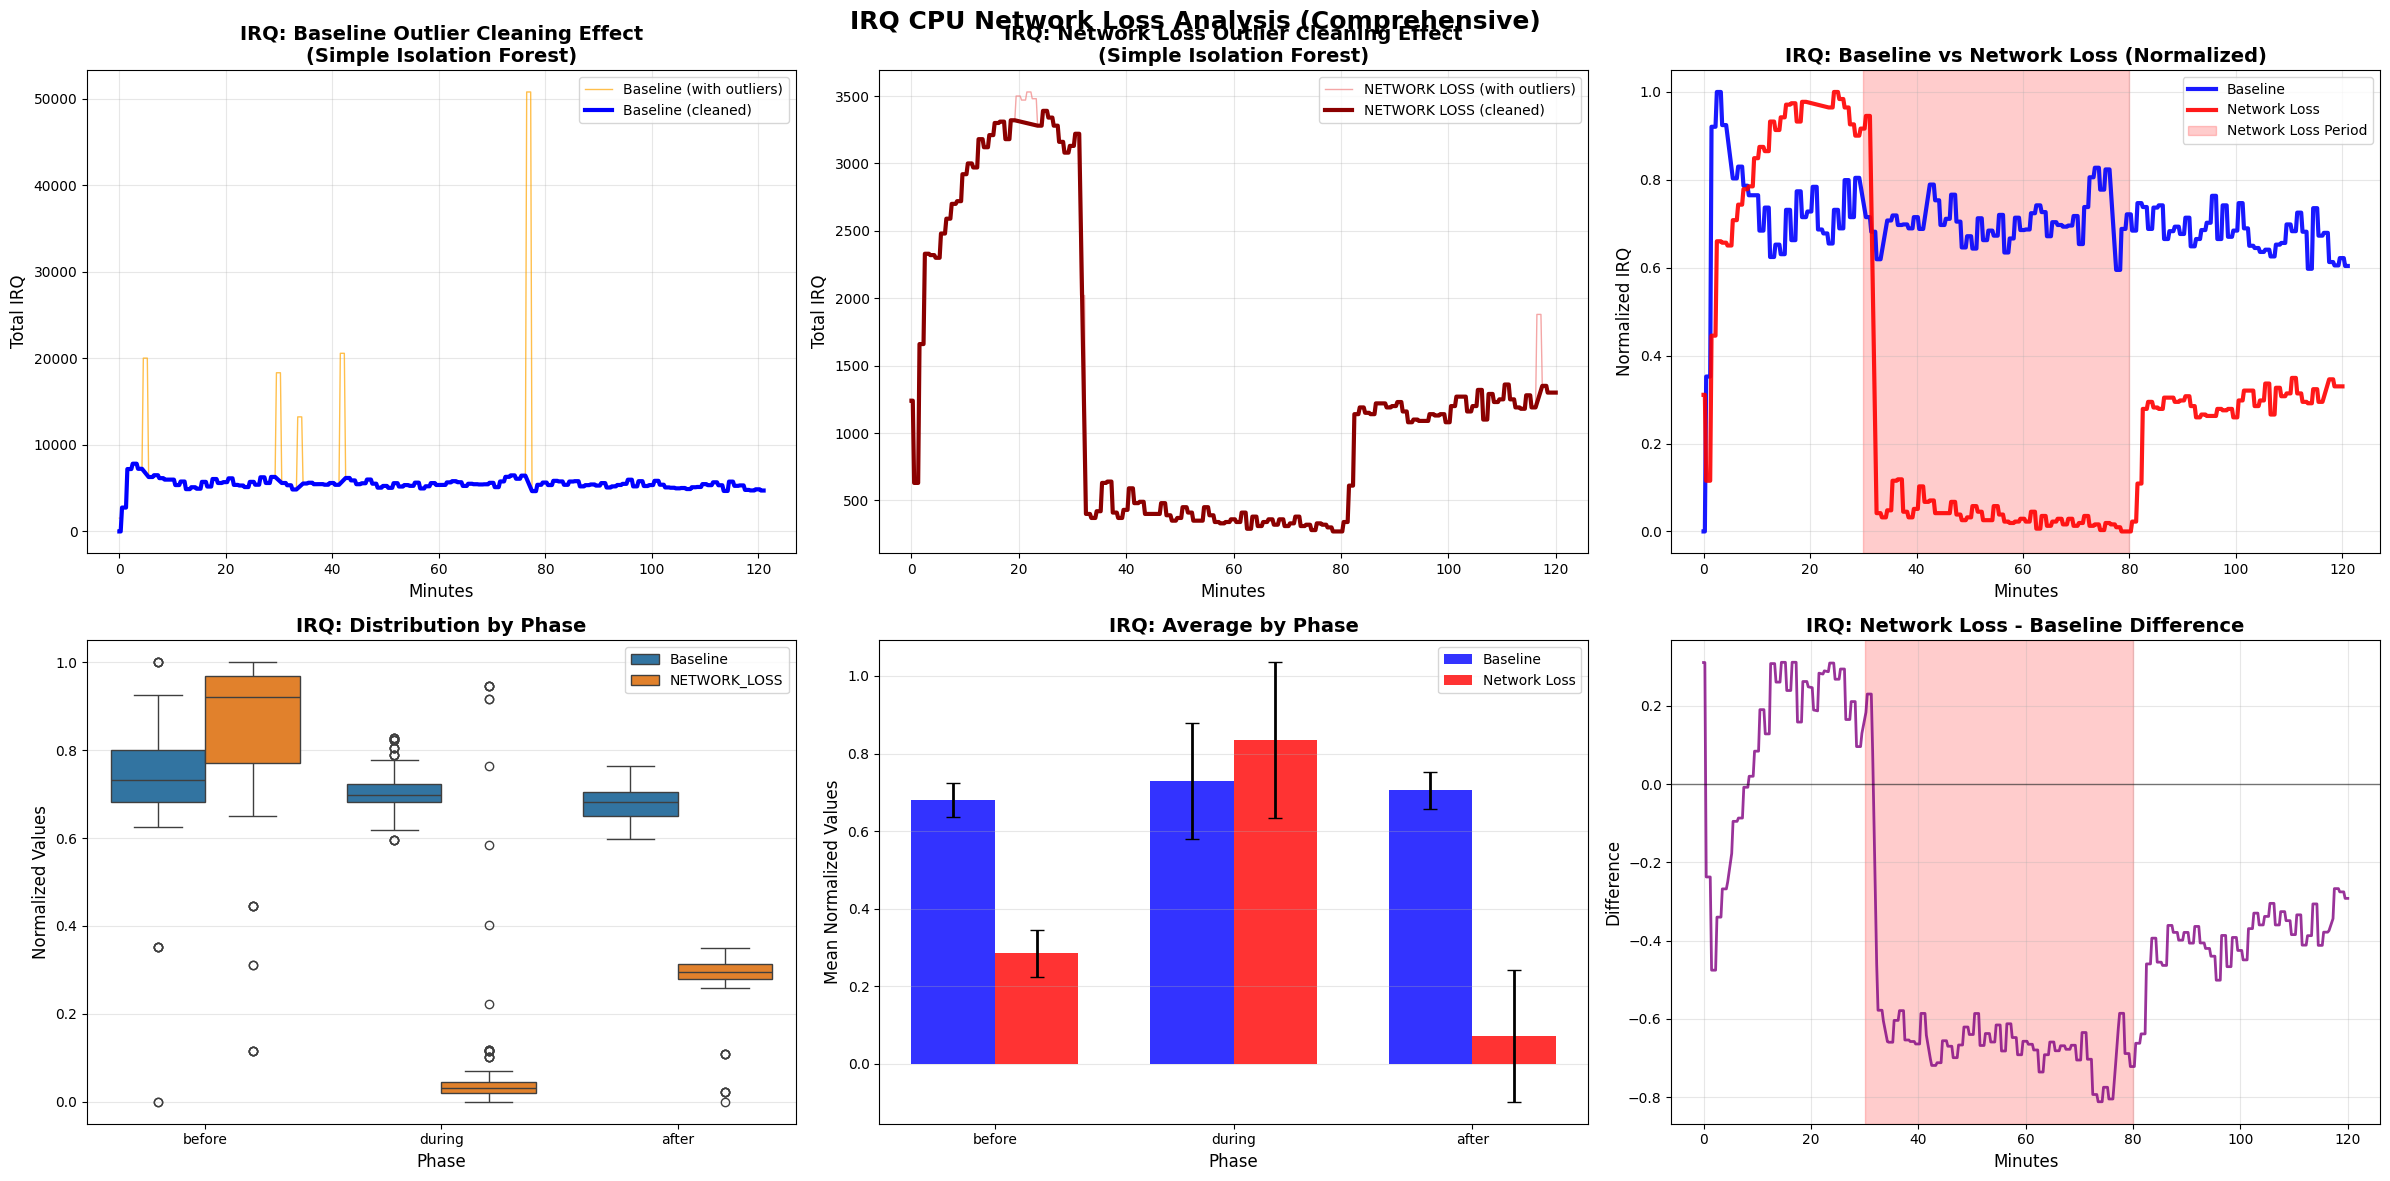


IRQ - CPU NETWORK LOSS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.6803  0.0427  0.5977  0.7637
before  0.7296  0.1487  0.0000  1.0000
during  0.7058  0.0475  0.5951  0.8276

📊 NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.2848  0.0613  0.0000  0.3494
before  0.8339  0.2012  0.1154  1.0000
during  0.0719  0.1693  0.0000  0.9455

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t= -4.57, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 51.11, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= 67.52, p=  0.0000 (✅ SIGNIFICANT)

📈 NETWORK LOSS IMPACT ON CPU (% CHANGE):
  BEFORE  :  +14.30% (↗️ INCREASE)
  DURING  :  -89.81% (↘️ DECREASE)
  AFTER   :  -58.14% (↘️ DECREASE)

📋 INDIVIDUAL CPU METRICS SUMMARY:
  CPU columns found: ['cpu 0', 'cpu 1', 'cpu 2', 'cpu 3', 'cpu 4', 'cpu 5', 'cpu 6', 'cpu 7', 'cpu 8', 'cpu 9']
  Total metrics analyze

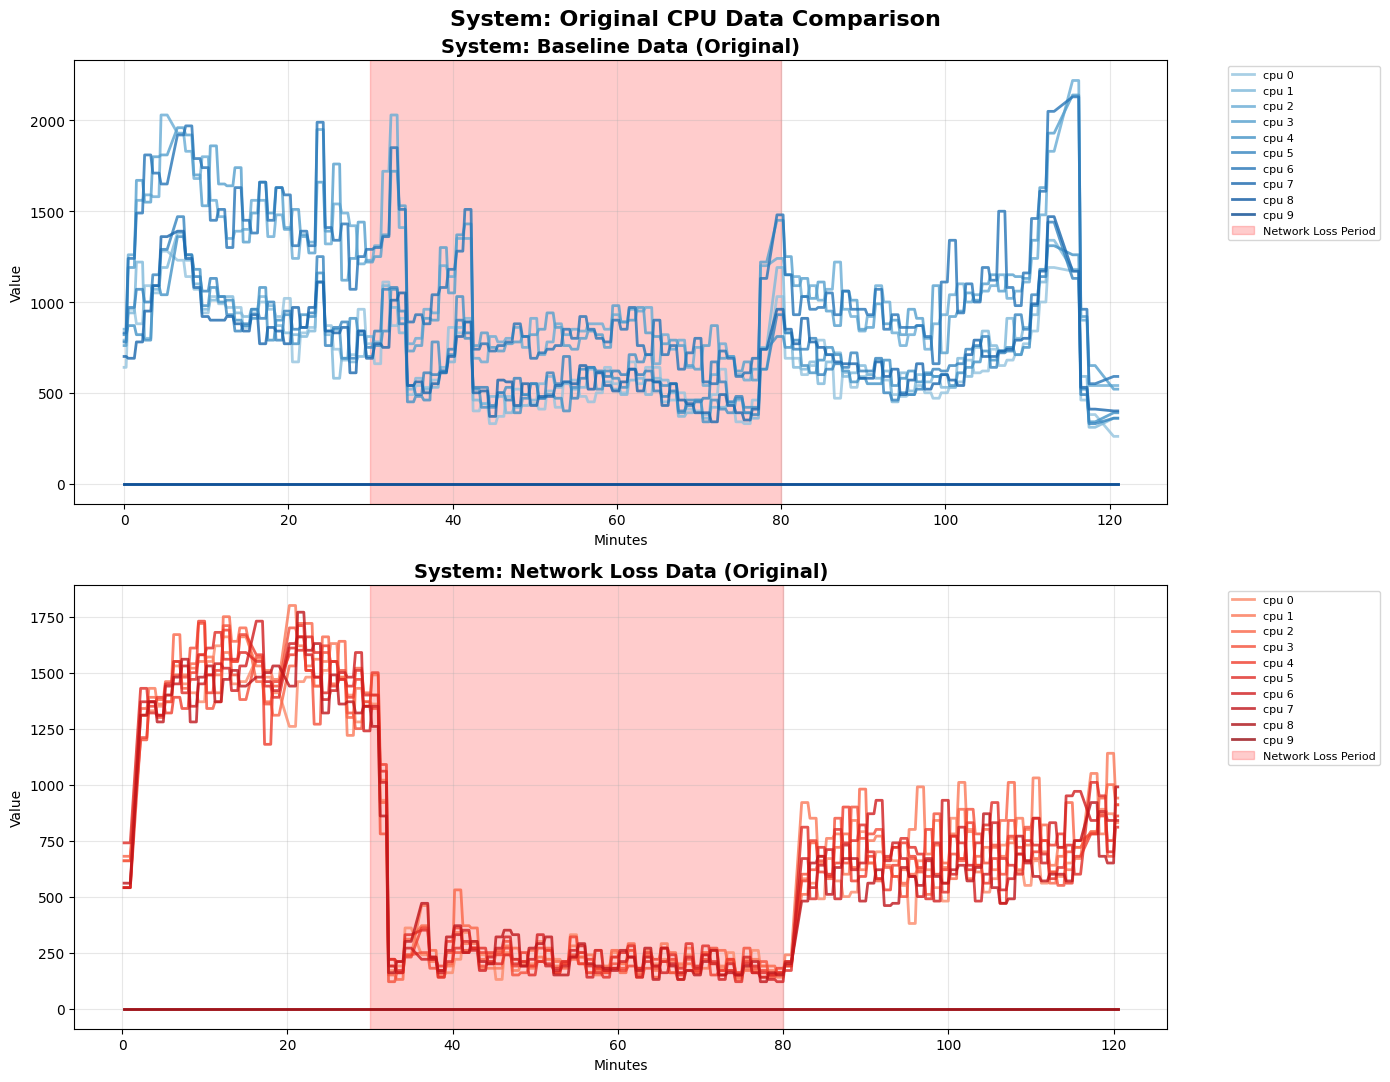

  💡 Displayed all 10 CPU columns: cpu 0, cpu 1, cpu 2, cpu 3, cpu 4, cpu 5, cpu 6, cpu 7, cpu 8, cpu 9


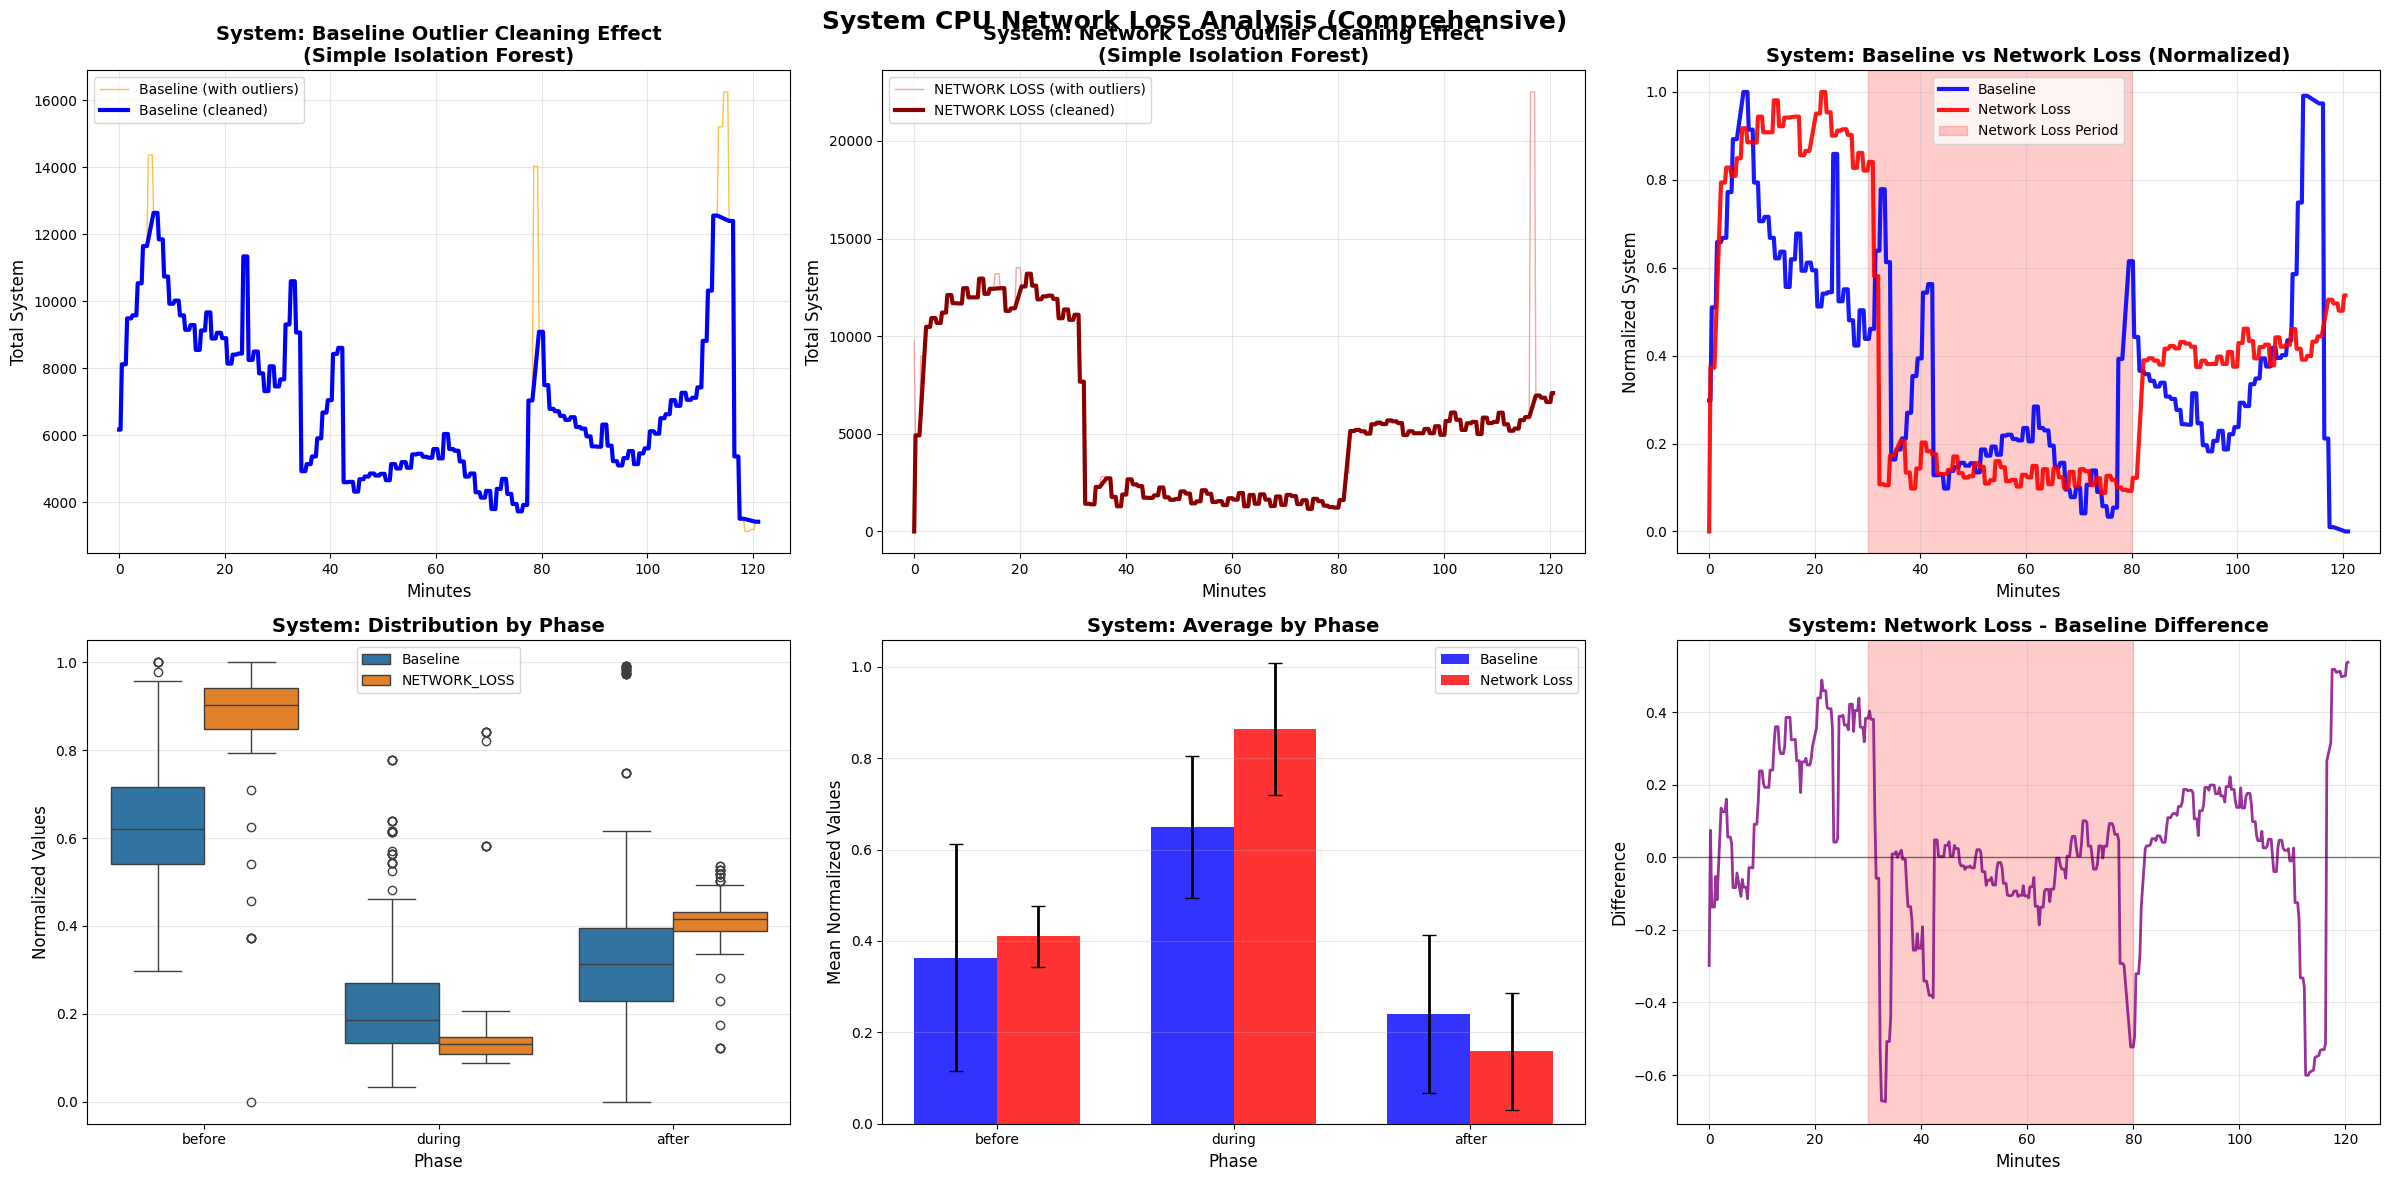


SYSTEM - CPU NETWORK LOSS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.3633  0.2484  0.0000  0.9913
before  0.6488  0.1556  0.2983  1.0000
during  0.2399  0.1734  0.0336  0.7787

📊 NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.4104  0.0666  0.1220  0.5371
before  0.8629  0.1446  0.0000  1.0000
during  0.1581  0.1287  0.0879  0.8409

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=-11.04, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t=  5.37, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t= -2.33, p=  0.0204 (✅ SIGNIFICANT)

📈 NETWORK LOSS IMPACT ON CPU (% CHANGE):
  BEFORE  :  +33.00% (↗️ INCREASE)
  DURING  :  -34.10% (↘️ DECREASE)
  AFTER   :  +12.96% (↗️ INCREASE)

📋 INDIVIDUAL CPU METRICS SUMMARY:
  CPU columns found: ['cpu 0', 'cpu 1', 'cpu 2', 'cpu 3', 'cpu 4', 'cpu 5', 'cpu 6', 'cpu 7', 'cpu 8', 'cpu 9']
  Total metrics anal

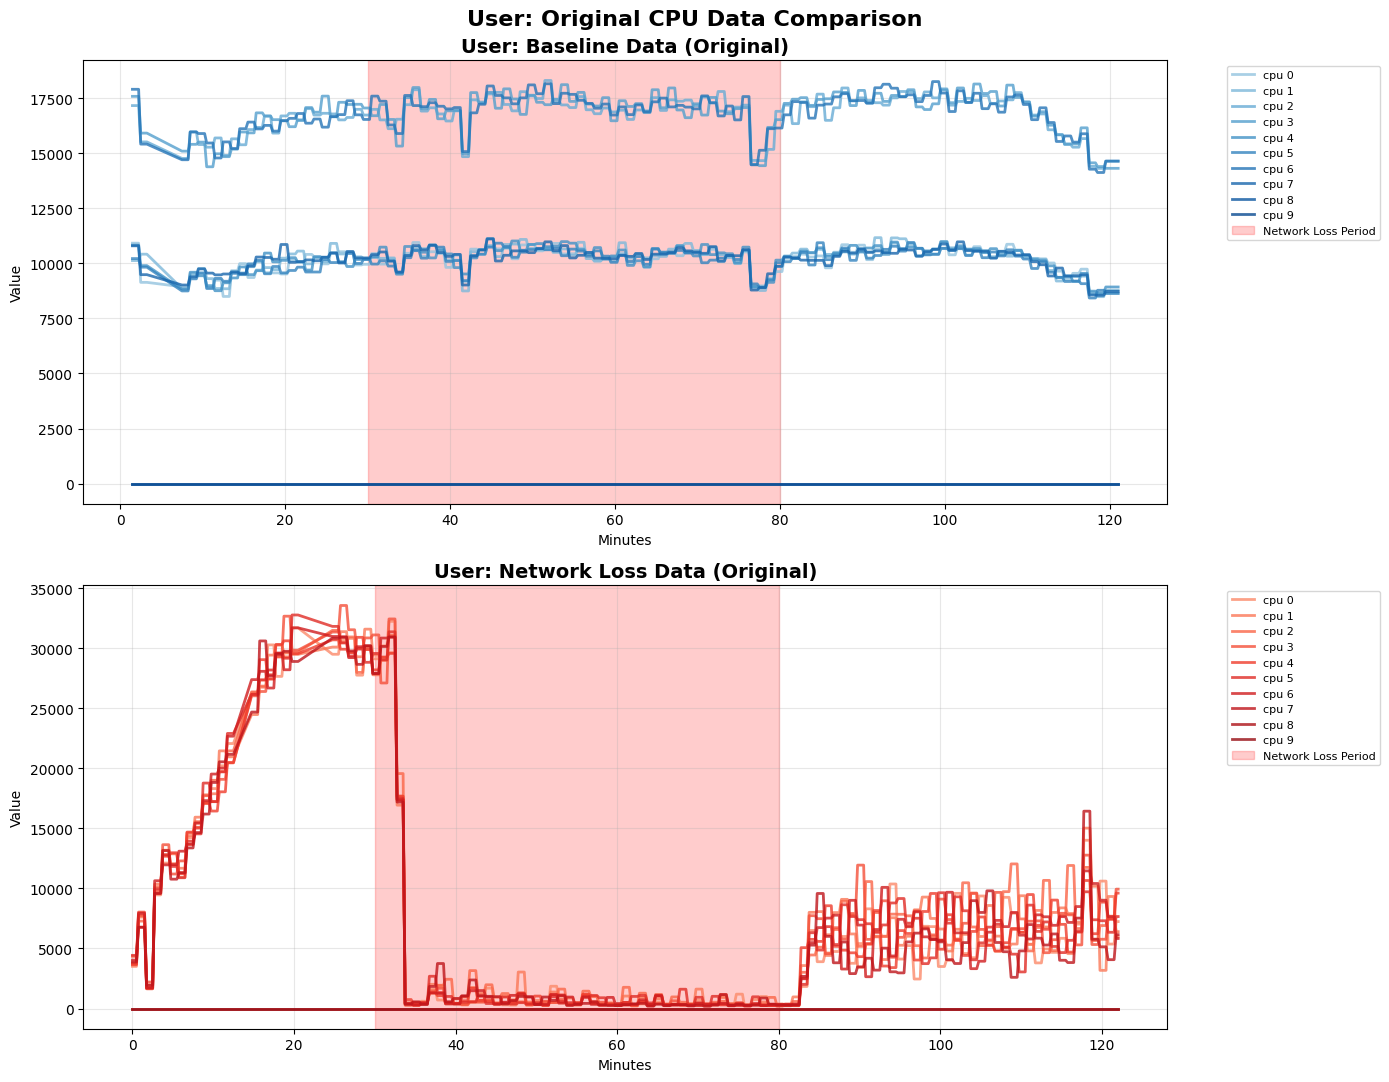

  💡 Displayed all 10 CPU columns: cpu 0, cpu 1, cpu 2, cpu 3, cpu 4, cpu 5, cpu 6, cpu 7, cpu 8, cpu 9


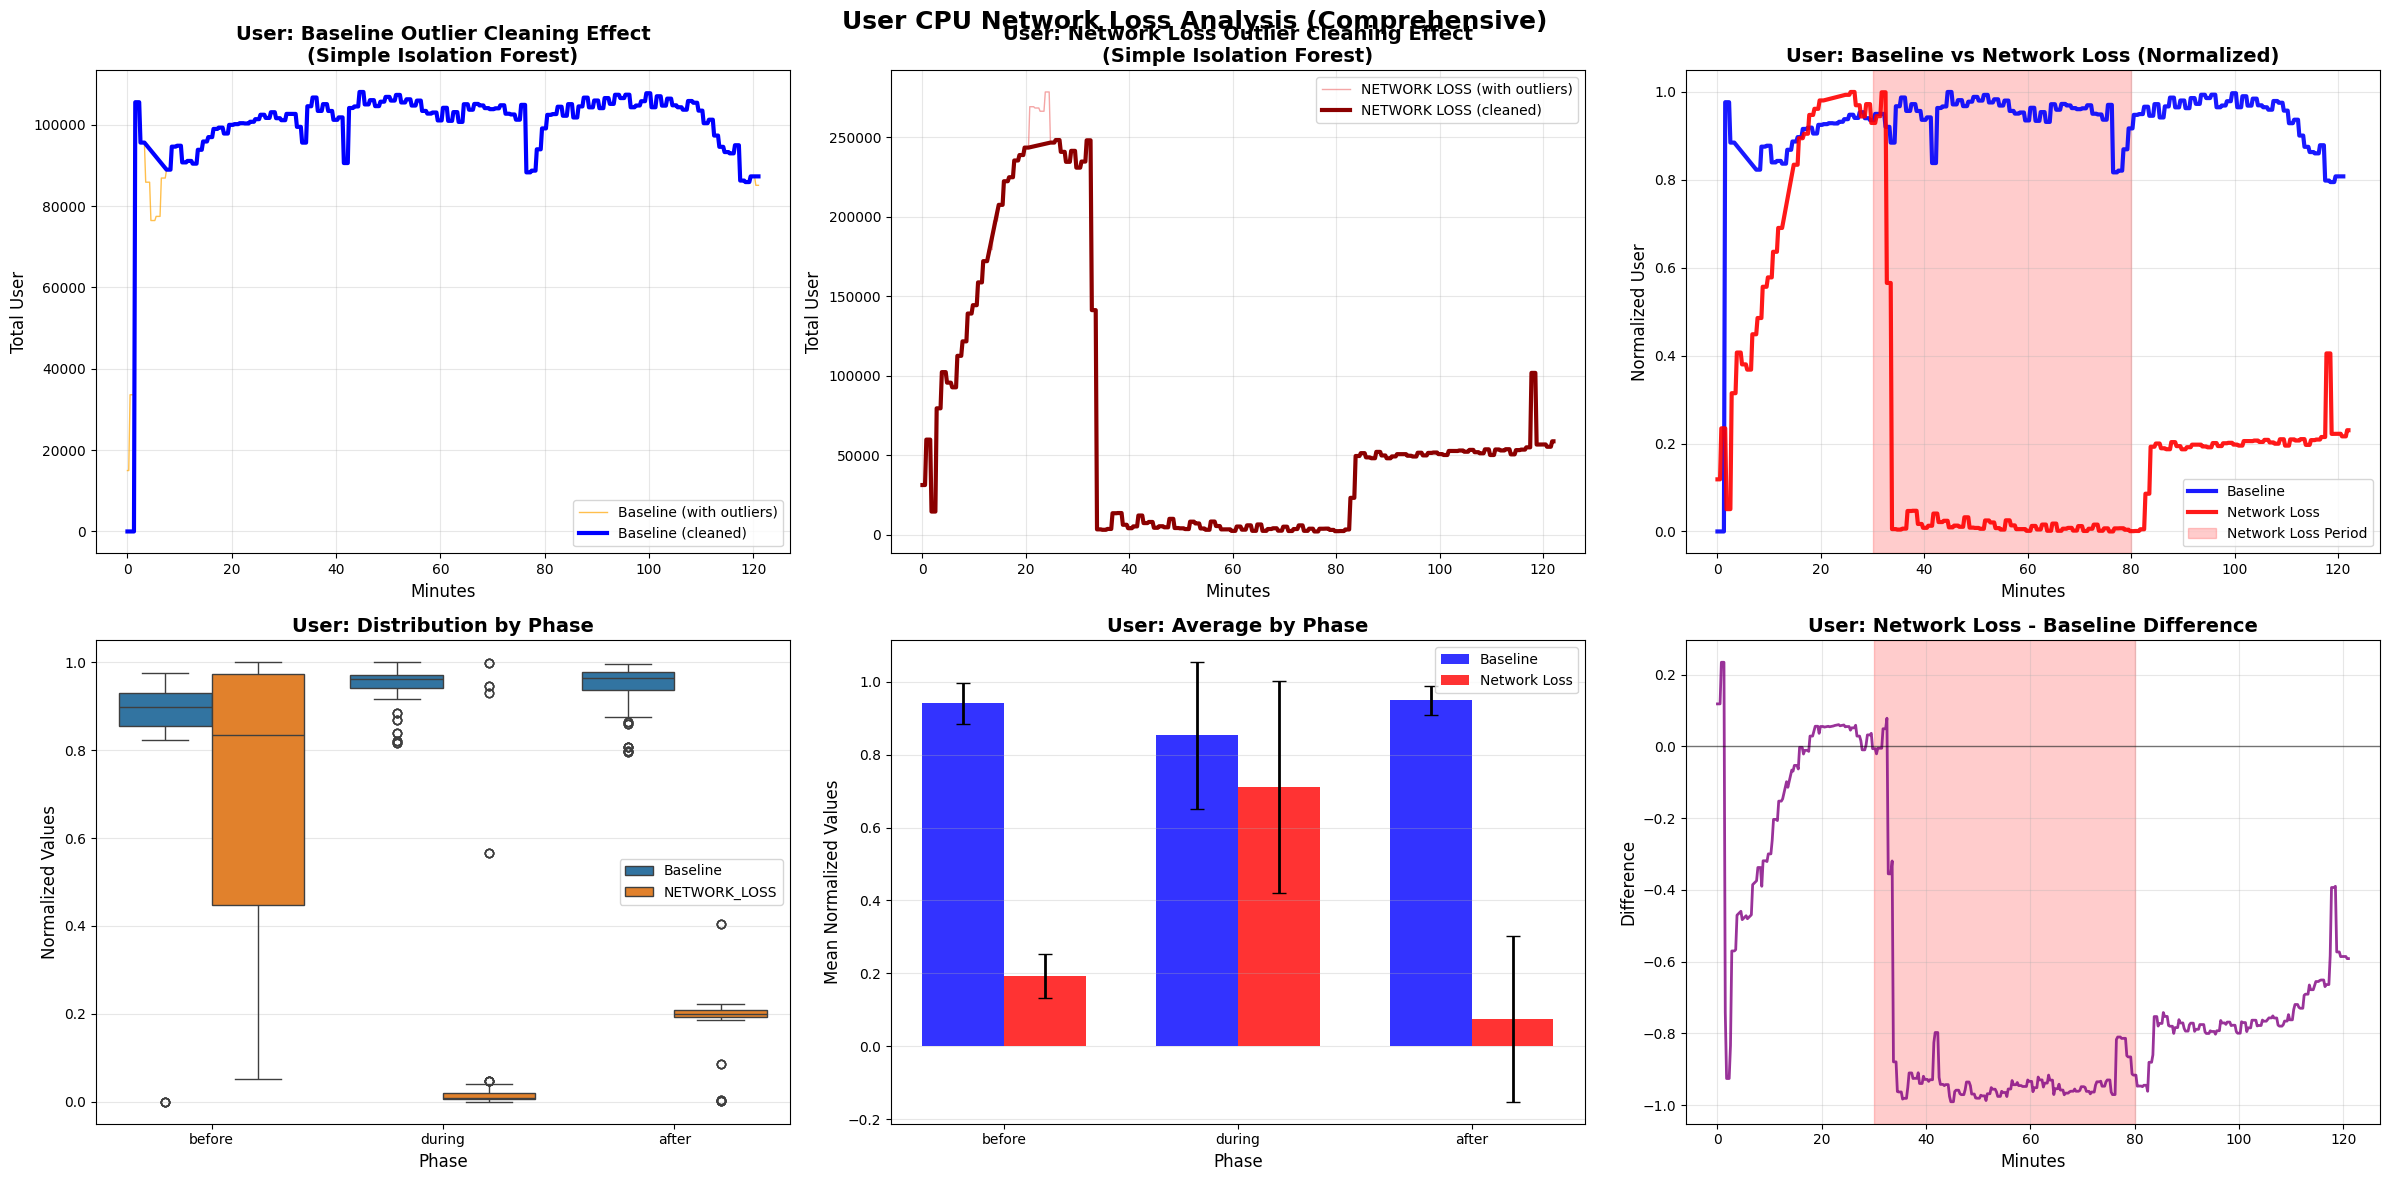


USER - CPU NETWORK LOSS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.9421  0.0564  0.7950  0.9971
before  0.8533  0.2008  0.0000  0.9767
during  0.9502  0.0397  0.8171  1.0000

📊 NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.1924  0.0607  0.0007  0.4051
before  0.7117  0.2914  0.0508  1.0000
during  0.0750  0.2276  0.0000  0.9993

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  4.38, p=  0.0000 (✅ SIGNIFICANT)
  DURING  : t= 53.71, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=115.52, p=  0.0000 (✅ SIGNIFICANT)

📈 NETWORK LOSS IMPACT ON CPU (% CHANGE):
  BEFORE  :  -16.59% (↘️ DECREASE)
  DURING  :  -92.10% (↘️ DECREASE)
  AFTER   :  -79.58% (↘️ DECREASE)

📋 INDIVIDUAL CPU METRICS SUMMARY:
  CPU columns found: ['cpu 0', 'cpu 1', 'cpu 2', 'cpu 3', 'cpu 4', 'cpu 5', 'cpu 6', 'cpu 7', 'cpu 8', 'cpu 9']
  Total metrics analyz

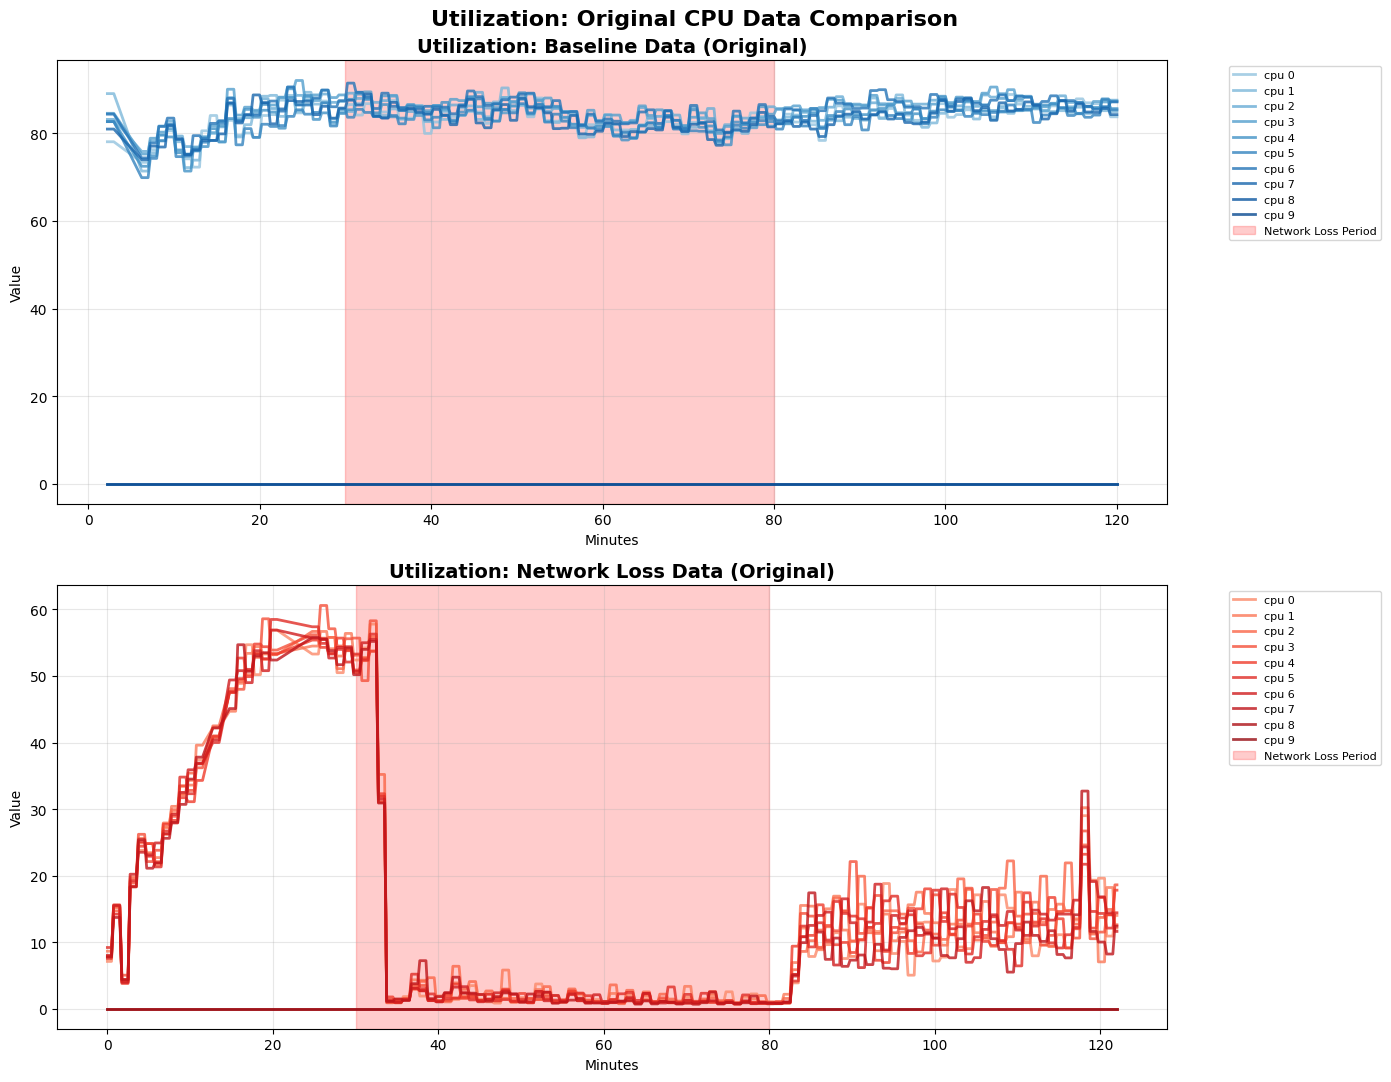

  💡 Displayed all 10 CPU columns: cpu 0, cpu 1, cpu 2, cpu 3, cpu 4, cpu 5, cpu 6, cpu 7, cpu 8, cpu 9


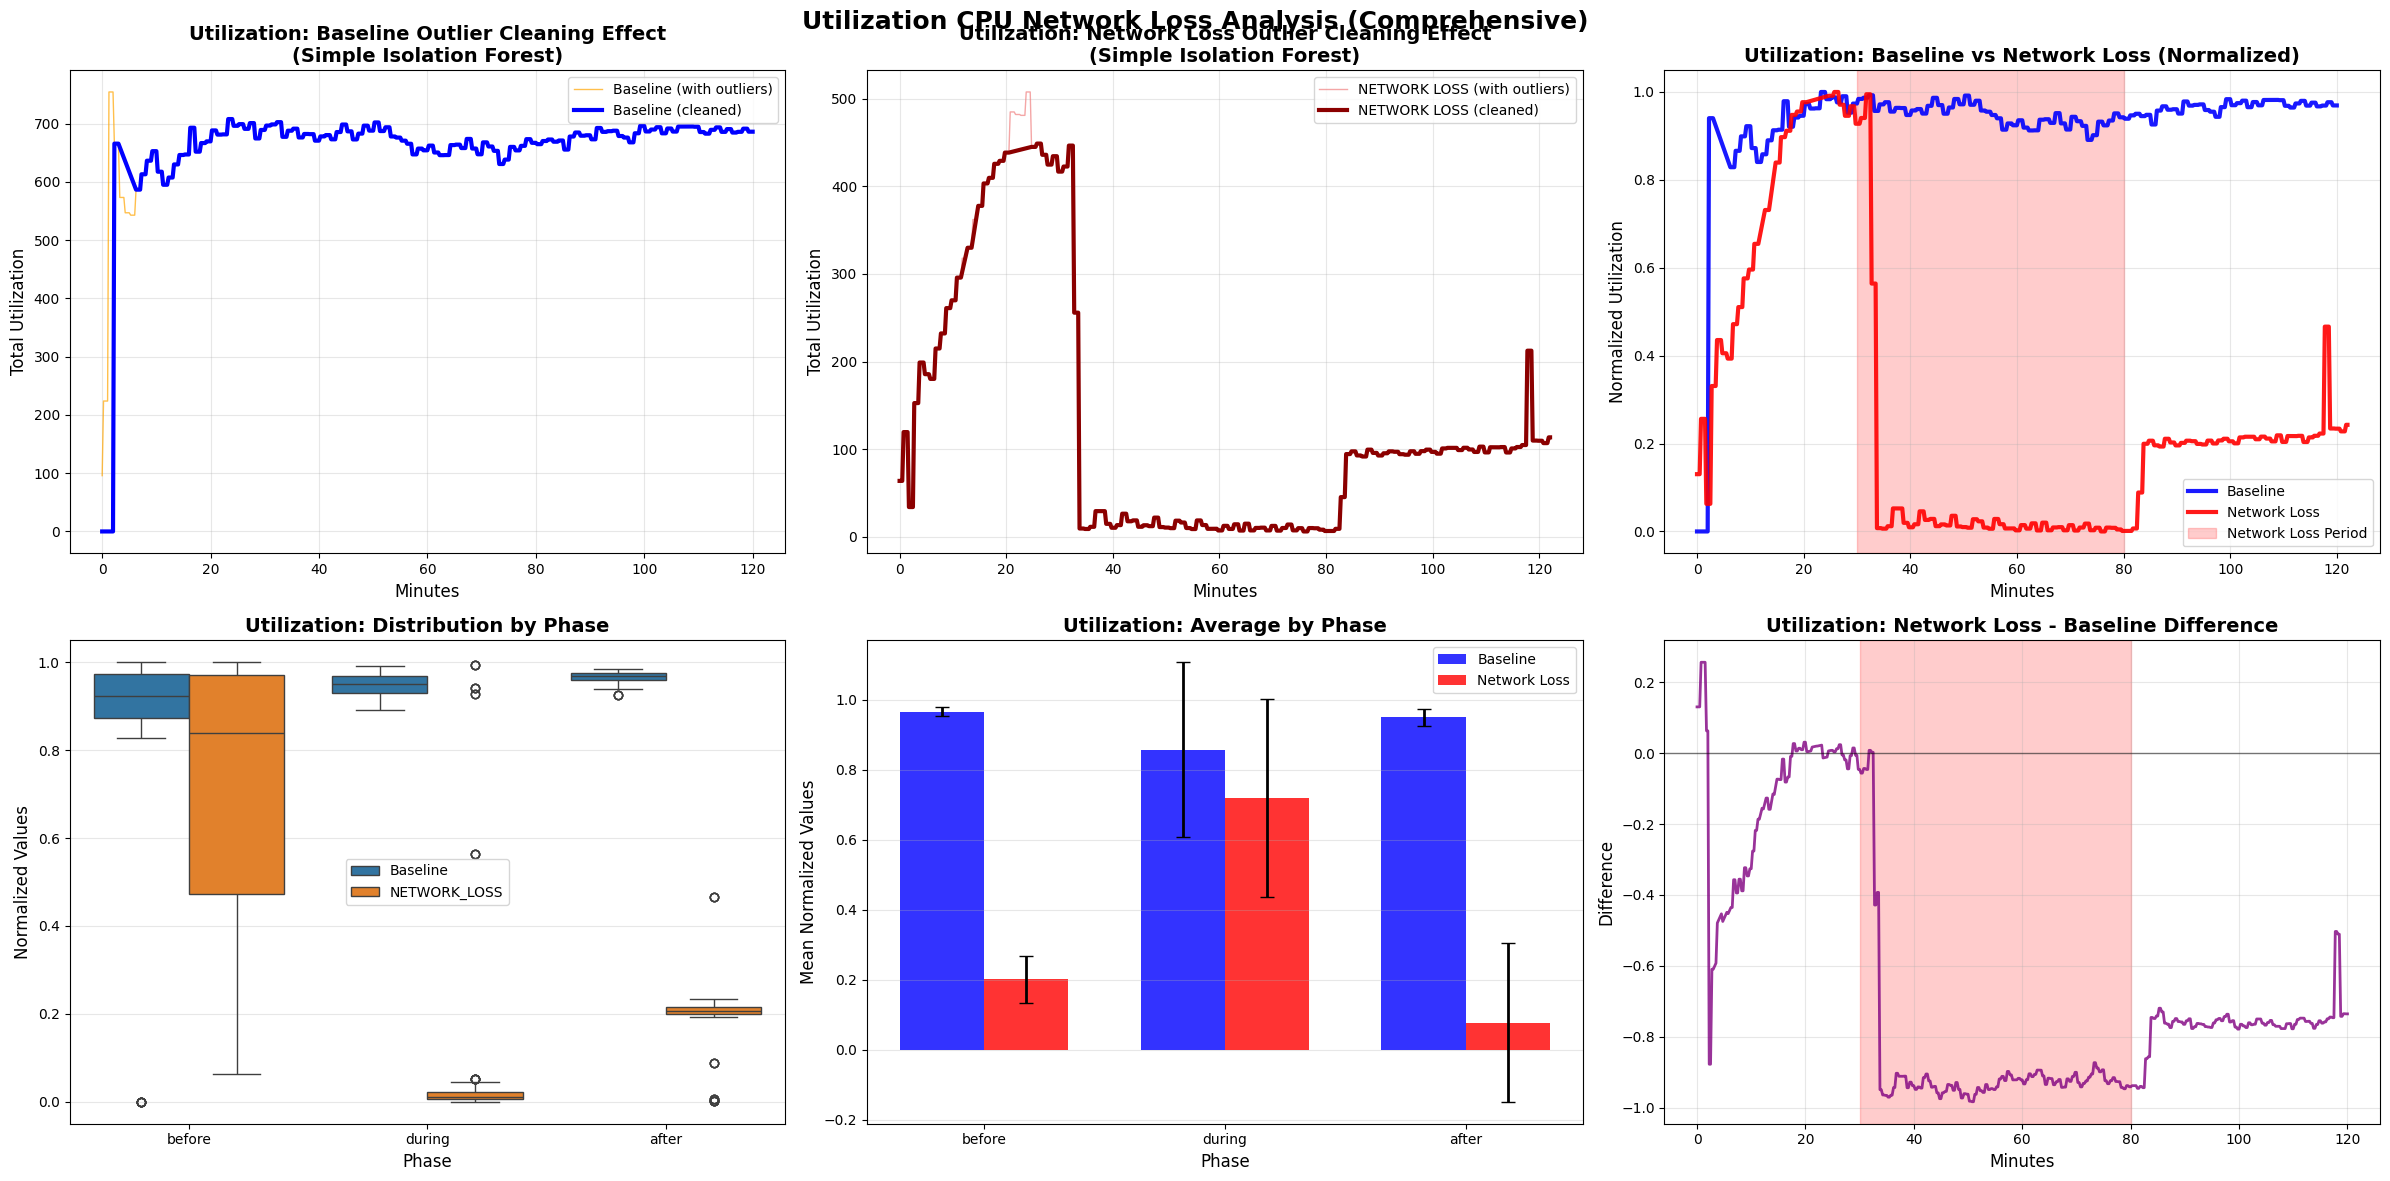


UTILIZATION - CPU NETWORK LOSS ANALYSIS RESULTS

📊 BASELINE STATISTICS BY PHASE:
          mean     std    min     max
phase                                
after   0.9656  0.0134  0.926  0.9836
before  0.8568  0.2496  0.000  1.0000
during  0.9488  0.0247  0.891  0.9925

📊 NETWORK LOSS STATISTICS BY PHASE:
          mean     std     min     max
phase                                 
after   0.2011  0.0671  0.0011  0.4660
before  0.7191  0.2823  0.0629  1.0000
during  0.0770  0.2262  0.0000  0.9948

🔬 STATISTICAL SIGNIFICANCE TESTS:
  BEFORE  : t=  4.00, p=  0.0001 (✅ SIGNIFICANT)
  DURING  : t= 54.33, p=  0.0000 (✅ SIGNIFICANT)
  AFTER   : t=139.16, p=  0.0000 (✅ SIGNIFICANT)

📈 NETWORK LOSS IMPACT ON CPU (% CHANGE):
  BEFORE  :  -16.08% (↘️ DECREASE)
  DURING  :  -91.89% (↘️ DECREASE)
  AFTER   :  -79.18% (↘️ DECREASE)

📋 INDIVIDUAL CPU METRICS SUMMARY:
  CPU columns found: ['cpu 0', 'cpu 1', 'cpu 2', 'cpu 3', 'cpu 4', 'cpu 5', 'cpu 6', 'cpu 7', 'cpu 8', 'cpu 9']
  Total metrics anal

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as scipy_stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Load all datasets
df_iowait = pd.read_csv("cpu_iowait.csv")
df_cpu_irq = pd.read_csv("cpu_irq.csv")
df_system_msec = pd.read_csv("cpu_system_msec.csv")
df_user_msec = pd.read_csv("cpu_user_msec.csv")
df_cpu_util = pd.read_csv("cpu_util_per.csv")

df_baseline_iowait = pd.read_csv("../../baseline/cpu related/cpu_iowait.csv")
df_baseline_irq = pd.read_csv("../../baseline/cpu related/cpu_irq.csv")
df_baseline_system_msec = pd.read_csv("../../baseline/cpu related/cpu_system_msec.csv")
df_baseline_user_msec = pd.read_csv("../../baseline/cpu related/cpu_user_msec.csv")
df_baseline_util_per = pd.read_csv("../../baseline/cpu related/cpu_util_per.csv")

# Add source labels - NETWORK LOSS
df_iowait["source"] = "NETWORK_LOSS"
df_cpu_irq["source"] = "NETWORK_LOSS"
df_system_msec["source"] = "NETWORK_LOSS"
df_user_msec["source"] = "NETWORK_LOSS"
df_cpu_util["source"] = "NETWORK_LOSS"

df_baseline_iowait["source"] = "BASELINE"
df_baseline_irq["source"] = "BASELINE"
df_baseline_system_msec["source"] = "BASELINE"
df_baseline_user_msec["source"] = "BASELINE"
df_baseline_util_per["source"] = "BASELINE"

# Convert to datetime
df_iowait["Time"] = pd.to_datetime(df_iowait["Time"])
df_cpu_irq["Time"] = pd.to_datetime(df_cpu_irq["Time"])
df_system_msec["Time"] = pd.to_datetime(df_system_msec["Time"])
df_user_msec["Time"] = pd.to_datetime(df_user_msec["Time"])
df_cpu_util["Time"] = pd.to_datetime(df_cpu_util["Time"])

df_baseline_iowait["Time"] = pd.to_datetime(df_baseline_iowait["Time"])
df_baseline_irq["Time"] = pd.to_datetime(df_baseline_irq["Time"])
df_baseline_system_msec["Time"] = pd.to_datetime(df_baseline_system_msec["Time"]) 
df_baseline_user_msec["Time"] = pd.to_datetime(df_baseline_user_msec["Time"])
df_baseline_util_per["Time"] = pd.to_datetime(df_baseline_util_per["Time"])

delay = 30
duration = 50

# Synchronize test datasets with baseline timeline
time_offset = df_baseline_iowait["Time"].min() - df_iowait["Time"].min()
df_iowait["Time"] += time_offset
df_cpu_irq["Time"] += time_offset
df_system_msec["Time"] += time_offset
df_user_msec["Time"] += time_offset
df_cpu_util["Time"] += time_offset

# Convert timeline to minutes 
all_dfs = [
    df_iowait, df_cpu_irq, df_system_msec, df_user_msec, df_cpu_util,
    df_baseline_iowait, df_baseline_irq, df_baseline_system_msec, 
    df_baseline_user_msec, df_baseline_util_per
]

for df in all_dfs:
    df["Minutes"] = (df["Time"] - df["Time"].min()).dt.total_seconds() / 60

# ORIGINAL DATASETS DICTIONARY 
original_datasets = {
    'IOWait': {'networkloss': df_iowait, 'baseline': df_baseline_iowait},
    'IRQ': {'networkloss': df_cpu_irq, 'baseline': df_baseline_irq},
    'System': {'networkloss': df_system_msec, 'baseline': df_baseline_system_msec},
    'User': {'networkloss': df_user_msec, 'baseline': df_baseline_user_msec},
    'Utilization': {'networkloss': df_cpu_util, 'baseline': df_baseline_util_per}
}

# ISOLATION FOREST OUTLIER DETECTION
def remove_outliers_isolation_forest_cpu(df, contamination=0.02):
    """Simple Isolation Forest outlier detection - uses only original numeric columns"""
    df_clean = df.copy()
    cpu_cols = [col for col in df.columns if col.startswith('cpu')]
    outlier_stats = {}
    
    if len(cpu_cols) == 0:
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': 0,
            'percentage_removed': 0
        }
        return df_clean, outlier_stats
    
    feature_matrix = df[cpu_cols].values
    
    # missing values ffill
    if np.isnan(feature_matrix).any():
        feature_matrix = pd.DataFrame(feature_matrix).fillna(method='ffill').fillna(method='bfill').values
    
    # Check if there's enough variance to detect outliers
    if np.std(feature_matrix.flatten()) > 1e-10:
        # Scale features for better performance
        scaler = StandardScaler()
        feature_matrix_scaled = scaler.fit_transform(feature_matrix)
        
        # Initialize and fit Isolation Forest
        iso_forest = IsolationForest(
            contamination=contamination,
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )
        
        iso_forest.fit(feature_matrix_scaled)
        outlier_predictions = iso_forest.predict(feature_matrix_scaled)
        
        outlier_mask = outlier_predictions == -1
        
        # Apply outlier removal to each CPU column
        for col in cpu_cols:
            outlier_stats[col] = {
                'count': outlier_mask.sum(),
                'percentage': (outlier_mask.sum() / len(df[col])) * 100,
                'method': 'isolation_forest_simple'
            }
            
            # Set outliers to NaN and interpolate
            df_clean.loc[outlier_mask, col] = np.nan
            df_clean[col] = df_clean[col].interpolate(method='linear')
        
        # Track statistics
        outlier_stats['_summary'] = {
            'total_outliers': outlier_mask.sum(),
            'contamination_rate': contamination,
            'features_used': len(cpu_cols),
            'percentage_removed': (outlier_mask.sum() / len(df)) * 100
        }
    else:
        # No variance - no outliers to remove
        for col in cpu_cols:
            outlier_stats[col] = {
                'count': 0,
                'percentage': 0,
                'method': 'isolation_forest_simple'
            }
        
        outlier_stats['_summary'] = {
            'total_outliers': 0,
            'contamination_rate': contamination,
            'features_used': len(cpu_cols),
            'percentage_removed': 0
        }
    
    return df_clean, outlier_stats

# APPLY OUTLIER CLEANING AND TRACK STATISTICS
datasets_clean = {}
all_outlier_stats = {}

for dataset_name, dataset_pair in original_datasets.items():
    print(f"\n📊 Processing {dataset_name} with Simple Isolation Forest:")
    
    datasets_clean[dataset_name] = {}
    all_outlier_stats[dataset_name] = {}
    
    for source_type, df in dataset_pair.items():
        print(f"  🔍 {source_type.upper().replace('_', ' ')}:")
        
        # Apply Isolation Forest outlier detection
        df_clean, stats = remove_outliers_isolation_forest_cpu(df, contamination=0.05)
        
        datasets_clean[dataset_name][source_type] = df_clean
        all_outlier_stats[dataset_name][source_type] = stats
        
        total_outliers = stats['_summary']['total_outliers']
        features_used = stats['_summary']['features_used']
        percentage_removed = stats['_summary']['percentage_removed']
        print(f"    ✅ Cleaned {total_outliers} outliers ({percentage_removed:.1f}%) using {features_used} original features")

# NORMALIZATION FUNCTION
def normalize_df_cpu(df, columns):
    result = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:  
            result[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            result[col] = 0
    return result

# ADD PHASE COLUMN
def add_phase_column(df, delay_minutes, duration_minutes):
    df = df.copy()
    df['phase'] = 'before'  
    df.loc[(df['Minutes'] >= delay_minutes) & (df['Minutes'] <= delay_minutes + duration_minutes), 'phase'] = 'during'  
    df.loc[df['Minutes'] > delay_minutes + duration_minutes, 'phase'] = 'after' 
    return df

# SIMPLE FUNCTION TO PLOT ORIGINAL DATA (NON-CUMULATIVE)
def plot_original_cpu_data(dataset_name, networkloss_df, baseline_df, delay_minutes, duration_minutes):
    """
    Plot 2 simple plots: one for baseline data and one for Network Loss data
    Shows ALL CPU columns in their original form (non-cumulative)
    """
    cpu_cols = [col for col in networkloss_df.columns if col.startswith('cpu')]
    
    if len(cpu_cols) == 0:
        print(f"No CPU columns found in {dataset_name}")
        return
    
    # Show ALL CPU columns 
    print(f"  📊 Showing all {len(cpu_cols)} CPU metrics")
    display_cols = cpu_cols  # Show all columns, not just first 5
    
    # Create 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 11))
    
    # Plot 1: Baseline Data (ALL CPU columns)
    colors_baseline = plt.cm.Blues(np.linspace(0.4, 0.9, len(display_cols)))
    for i, cpu_col in enumerate(display_cols):
        ax1.plot(baseline_df['Minutes'], baseline_df[cpu_col], 
                color=colors_baseline[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax1.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Loss Period")
    ax1.set_title(f'{dataset_name}: Baseline Data (Original)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Minutes')
    ax1.set_ylabel('Value')
    ax1.grid(True, alpha=0.3)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    # Plot 2: Network Loss Data (ALL CPU columns)
    colors_stress = plt.cm.Reds(np.linspace(0.4, 0.9, len(display_cols)))
    for i, cpu_col in enumerate(display_cols):
        ax2.plot(networkloss_df['Minutes'], networkloss_df[cpu_col], 
                color=colors_stress[i], linewidth=2, alpha=0.8, 
                label=cpu_col)
    
    ax2.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Loss Period")
    ax2.set_title(f'{dataset_name}: Network Loss Data (Original)', fontweight='bold', fontsize=14)
    ax2.set_xlabel('Minutes')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.suptitle(f'{dataset_name}: Original CPU Data Comparison', 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"  💡 Displayed all {len(cpu_cols)} CPU columns: {', '.join(cpu_cols)}")

# ENHANCED ANALYSIS AND PLOT FUNCTION FOR CPU NETWORK LOSS
def analyze_and_plot_cpu_dataset_wide(dataset_name, networkloss_df_clean, baseline_df_clean, delay_minutes, duration_minutes):
    cpu_cols = [col for col in networkloss_df_clean.columns if col.startswith('cpu')]
    
    # Plot the original data (non-cumulative) - 2 simple plots first
    print(f"\n📊 Plotting original CPU data for {dataset_name}...")
    plot_original_cpu_data(dataset_name, networkloss_df_clean, baseline_df_clean, delay_minutes, duration_minutes)
    
    # Get original datasets for comparison
    networkloss_df_original = original_datasets[dataset_name]['networkloss']
    baseline_df_original = original_datasets[dataset_name]['baseline']
    
    networkloss_norm = normalize_df_cpu(networkloss_df_clean, cpu_cols)
    baseline_norm = normalize_df_cpu(baseline_df_clean, cpu_cols)
    
    # Calculate cumulative metrics
    networkloss_df_clean['Total'] = networkloss_df_clean[cpu_cols].sum(axis=1)
    baseline_df_clean['Total'] = baseline_df_clean[cpu_cols].sum(axis=1)
    
    # Normalize totals
    networkloss_norm['Total'] = (networkloss_df_clean['Total'] - networkloss_df_clean['Total'].min()) / (networkloss_df_clean['Total'].max() - networkloss_df_clean['Total'].min())
    baseline_norm['Total'] = (baseline_df_clean['Total'] - baseline_df_clean['Total'].min()) / (baseline_df_clean['Total'].max() - baseline_df_clean['Total'].min())
    
    # Add phase information
    networkloss_norm = add_phase_column(networkloss_norm, delay_minutes, duration_minutes)
    baseline_norm = add_phase_column(baseline_norm, delay_minutes, duration_minutes)
    
    # Statistical analysis
    stats_baseline = baseline_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    stats_networkloss = networkloss_norm.groupby('phase')['Total'].agg(['mean', 'std', 'min', 'max'])
    
    # Combined dataframe for analysis
    df_combined = pd.DataFrame({
        'Baseline': baseline_norm['Total'],
        'NETWORK_LOSS': networkloss_norm['Total'],
        'Minutes': baseline_norm['Minutes'],
        'phase': baseline_norm['phase'],
        'difference': networkloss_norm['Total'] - baseline_norm['Total']
    })
    
    # T-tests for statistical significance
    t_tests = {}
    for phase in ['before', 'during', 'after']:
        data = df_combined[df_combined['phase'] == phase]
        t_stat, p_value = scipy_stats.ttest_ind(data['Baseline'].dropna(), data['NETWORK_LOSS'].dropna())
        t_tests[phase] = {'t': t_stat, 'p': p_value}
    
    # Calculate percentage impact
    impact = {}
    for phase in ['before', 'during', 'after']:
        baseline_mean = stats_baseline.loc[phase, 'mean']
        networkloss_mean = stats_networkloss.loc[phase, 'mean']
        impact[phase] = ((networkloss_mean - baseline_mean) / baseline_mean) * 100 if baseline_mean != 0 else float('inf')
    
    # COMPREHENSIVE ANALYSIS PLOTTING (6-plot dashboard)
    fig = plt.figure(figsize=(24, 12))
    
    # 1. Baseline outlier cleaning effect
    plt.subplot(2, 3, 1)
    plt.plot(baseline_df_original['Minutes'], baseline_df_original[cpu_cols].sum(axis=1), 
             label='Baseline (with outliers)', color='orange', alpha=0.7, linewidth=1)
    plt.plot(baseline_df_clean['Minutes'], baseline_df_clean['Total'], 
             label='Baseline (cleaned)', linewidth=3, color='blue')
    plt.title(f'{dataset_name}: Baseline Outlier Cleaning Effect\n(Simple Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 2. NETWORK LOSS outlier cleaning effect
    plt.subplot(2, 3, 2)
    plt.plot(networkloss_df_original['Minutes'], networkloss_df_original[cpu_cols].sum(axis=1), 
             label='NETWORK LOSS (with outliers)', alpha=0.7, color='lightcoral', linewidth=1)
    plt.plot(networkloss_df_clean['Minutes'], networkloss_df_clean['Total'], 
             label='NETWORK LOSS (cleaned)', linewidth=3, color='darkred')
    plt.title(f'{dataset_name}: Network Loss Outlier Cleaning Effect\n(Simple Isolation Forest)', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel(f'Total {dataset_name}', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # 3. Timeline comparison (cumulative)
    plt.subplot(2, 3, 3)
    plt.plot(baseline_norm['Minutes'], baseline_norm['Total'], 
             label='Baseline', linewidth=3, color='blue', alpha=0.9)
    plt.plot(networkloss_norm['Minutes'], networkloss_norm['Total'], 
             label='Network Loss', linewidth=3, color='red', alpha=0.9)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2, label="Network Loss Period")
    plt.title(f"{dataset_name}: Baseline vs Network Loss (Normalized)", fontsize=14, fontweight='bold')
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel(f"Normalized {dataset_name}", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # 4. Box plot by phase
    plt.subplot(2, 3, 4)
    box_data = pd.melt(df_combined[['Baseline', 'NETWORK_LOSS', 'phase']], 
                      id_vars=['phase'], var_name='source', value_name='value')
    sns.boxplot(x='phase', y='value', hue='source', data=box_data, ax=plt.gca())
    plt.title(f'{dataset_name}: Distribution by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Normalized Values', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(fontsize=10)
    
    # 5. Statistics by phase
    plt.subplot(2, 3, 5)
    phases = ['before', 'during', 'after']
    x = np.arange(len(phases))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, stats_baseline['mean'], width, label='Baseline', alpha=0.8, color='blue')
    bars2 = plt.bar(x + width/2, stats_networkloss['mean'], width, label='Network Loss', alpha=0.8, color='red')
    
    plt.errorbar(x - width/2, stats_baseline['mean'], yerr=stats_baseline['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    plt.errorbar(x + width/2, stats_networkloss['mean'], yerr=stats_networkloss['std'], 
                fmt='none', ecolor='black', capsize=5, linewidth=2)
    
    plt.title(f'{dataset_name}: Average by Phase', fontsize=14, fontweight='bold')
    plt.xlabel('Phase', fontsize=12)
    plt.ylabel('Mean Normalized Values', fontsize=12)
    plt.xticks(x, phases)
    plt.legend(fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    
    # 6. Difference over time
    plt.subplot(2, 3, 6)
    plt.plot(df_combined['Minutes'], df_combined['difference'], 
             color='purple', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5, linewidth=1)
    plt.axvspan(delay_minutes, delay_minutes + duration_minutes, 
                color='red', alpha=0.2)
    plt.title(f'{dataset_name}: Network Loss - Baseline Difference', fontsize=14, fontweight='bold')
    plt.xlabel('Minutes', fontsize=12)
    plt.ylabel('Difference', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'{dataset_name} CPU Network Loss Analysis (Comprehensive)', 
                fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print statistical results
    print(f"\n{'='*80}")
    print(f"{dataset_name.upper()} - CPU NETWORK LOSS ANALYSIS RESULTS")
    print(f"{'='*80}")
    
    print(f"\n📊 BASELINE STATISTICS BY PHASE:")
    print(stats_baseline.round(4))
    
    print(f"\n📊 NETWORK LOSS STATISTICS BY PHASE:")
    print(stats_networkloss.round(4))
    
    print(f"\n🔬 STATISTICAL SIGNIFICANCE TESTS:")
    for phase, test in t_tests.items():
        sig = "✅ SIGNIFICANT" if test['p'] < 0.05 else "❌ NOT SIGNIFICANT"
        print(f"  {phase.upper():8}: t={test['t']:6.2f}, p={test['p']:8.4f} ({sig})")
    
    print(f"\n📈 NETWORK LOSS IMPACT ON CPU (% CHANGE):")
    for phase, change in impact.items():
        direction = "↗️ INCREASE" if change > 0 else "↘️ DECREASE" if change < 0 else "→ NO CHANGE"
        print(f"  {phase.upper():8}: {change:+7.2f}% ({direction})")
    
    # Print individual CPU metrics summary
    print(f"\n📋 INDIVIDUAL CPU METRICS SUMMARY:")
    print(f"  CPU columns found: {cpu_cols}")
    print(f"  Total metrics analyzed: {len(cpu_cols)}")
    
    return {
        'stats_baseline': stats_baseline,
        'stats_networkloss': stats_networkloss,
        't_tests': t_tests,
        'impact': impact,
        'combined_data': df_combined,
        'cpu_columns': cpu_cols
    }

# RUN ANALYSIS 
print(f"\n{'='*80}")
print("COMPREHENSIVE CPU NETWORK LOSS ANALYSIS - WITH ORIGINAL PLOTS")
print(f"{'='*80}")

analysis_results = {}

for dataset_name in datasets_clean.keys():
    print(f"\n🔄 Analyzing {dataset_name}...")
    
    networkloss_clean = datasets_clean[dataset_name]['networkloss']
    baseline_clean = datasets_clean[dataset_name]['baseline']
    
    analysis_results[dataset_name] = analyze_and_plot_cpu_dataset_wide(
        dataset_name, 
        networkloss_clean, 
        baseline_clean, 
        delay, 
        duration
    )

# FINAL COMPREHENSIVE SUMMARY
print(f"\n{'='*100}")
print("COMPREHENSIVE CPU NETWORK LOSS IMPACT SUMMARY")
print(f"{'='*100}")

summary_table = []
for dataset_name, results in analysis_results.items():
    if results:  # Check if analysis was successful
        for phase in ['before', 'during', 'after']:
            summary_table.append({
                'CPU_Metric': dataset_name,
                'Phase': phase,
                'Impact (%)': f"{results['impact'][phase]:+.1f}%",
                'P-Value': f"{results['t_tests'][phase]['p']:.4f}",
                'Significant': 'YES' if results['t_tests'][phase]['p'] < 0.05 else 'NO',
                'T-Statistic': f"{results['t_tests'][phase]['t']:.2f}",
                'CPU_Columns': len(results['cpu_columns'])
            })

if summary_table:
    summary_df = pd.DataFrame(summary_table)
    print(summary_df.to_string(index=False, col_space=12))

# OUTLIER DETECTION SUMMARY
print(f"\n{'='*80}")
print("SIMPLE ISOLATION FOREST OUTLIER DETECTION SUMMARY")
print(f"{'='*80}")

for dataset_name, outlier_data in all_outlier_stats.items():
    print(f"\n📊 {dataset_name.upper()}:")
    for source_type, stats in outlier_data.items():
        if '_summary' in stats:
            summary = stats['_summary']
            print(f"  {source_type.upper()}:")
            print(f"    Total outliers removed: {summary['total_outliers']}")
            print(f"    Percentage removed: {summary['percentage_removed']:.1f}%")
            print(f"    Features used: {summary['features_used']} (original columns only)")
            print(f"    Contamination rate: {summary['contamination_rate']*100:.1f}%")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE - CPU WITH ORIGINAL DATA PLOTS!")
print(f"{'='*80}")